<center><h1>Esquema de Euler-Cromer</h1></center>
<center><h5>Sebastián Marroquín Martínez</h5></center>



En este esquema de Euler-Cromer tomamos una diferencia hacia adelante de (1) y una diferencia hacia atrás de (2), de la siguiente manera:

$
\begin{align}
\frac{v^{n+1}-v^n}{\Delta t} &= \frac{1}{m}\left(F(t_n) - s(u^n) - f(v^n)\right),
\tag{1}\\ 
\frac{u^{n+1}-u^n}{\Delta t} &= v^{n+1},
\tag{2}
\end{align}
$

Podemos resolver fácilmente las nuevas incógnitas que son: $v^{n+1}$ y $u^{n+1}$:

$
\begin{align}
v^{n+1} &= v^n + \frac{\Delta t}{m}\left(F(t_n) - s(u^n) - f(v^n)\right),
\tag{4.72}\\ 
u^{n+1} &= u^n + \Delta t v^{n+1}\thinspace .
\tag{4.73}
\end{align}
$


La siguiente función implementa el método de Euler-Cromer

In [ ]:
def EulerCromer(f, s, F, m, T, U_0, V_0, dt):
    from numpy import zeros, linspace
    N_t = int(round(T/dt))
    print 'N_t:', N_t
    t = linspace(0, N_t*dt, N_t+1)

    u = zeros(N_t+1)
    v = zeros(N_t+1)

    # Condiciones iniciales
    u[0] = U_0
    v[0] = V_0

    # Paso de las ecuaciones en el tiempo
    for n in range(N_t):
        v[n+1] = v[n] + dt*(1./m)*(F(t[n]) - f(v[n]) - s(u[n]))
        u[n+1] = u[n] + dt*v[n+1]
    return u, v, t

Implementación 
-------------



In [ ]:
from matplotlib.pyplot import plot, hold, legend, \
     xlabel, ylabel, savefig, title, figure, show

def EulerCromer(f, s, F, m, T, U_0, V_0, dt):
    from numpy import zeros, linspace
    N_t = int(round(T/dt))
    print 'N_t:', N_t
    t = linspace(0, N_t*dt, N_t+1)

    u = zeros(N_t+1)
    v = zeros(N_t+1)

    # Condiciones iniciales
    u[0] = U_0
    v[0] = V_0

    # Ecuaciones hacia adelante en el tiempo
    for n in range(N_t):
        v[n+1] = v[n] + dt*(1./m)*(F(t[n]) - f(v[n]) - s(u[n]))
        u[n+1] = u[n] + dt*v[n+1]
    return u, v, t

def test_undamped_linear():
    """Comparamos los datos con los de  osc_EC.py  (que les envié) del problema lineal."""
    from numpy import pi
    omega = 2
    P = 2*pi/omega
    dt = P/20
    T = 40*P
    exact_v = -3.5035725322034139
    exact_u = 0.7283057044967003
    computed_u, computed_v, t = EulerCromer(
        f=lambda v: 0, s=lambda u: omega**2*u,
        F=lambda t: 0, m=1, T=T, U_0=2, V_0=0, dt=dt)
    diff_u = abs(exact_u - computed_u[-1])
    diff_v = abs(exact_v - computed_v[-1])
    tol = 1E-14
    assert diff_u < tol and diff_v < tol

def _test_manufactured_solution(damping=True):
    import sympy as sp
    t, m, k, b = sp.symbols('t m k b')
    # escogiendo solucion
    u = sp.sin(t)
    v = sp.diff(u, t)
    # Escogiendo f, s, F
    f = b*v
    s = k*sp.tanh(u)
    F = sp.cos(2*t)

    equation = m*sp.diff(v, t) + f + s - F

    # Ajustando  F (termino fuente )
    F += equation
    print 'F:', F

    # Inicializando valores para  m, b, k
    m = 0.5
    k = 1.5
    b = 0.5 if damping else 0
    F = F.subs('m', m).subs('b', b).subs('k', k)

    print f, s, F
    # Convirtiendo una expresion de sympy en una funcion de  Python 
    F = sp.lambdify([t], F)
    # Definimos las funciones de  Python para f y s
    # (las expresiones de arriba son funciones de t, necesitamos los valores de 
    # s(u) y f(v)
    from numpy import tanh
    s = lambda u: k*tanh(u)
    f = lambda v: b*v

    # agregando los modulos ='numpy' de tal manera que  u y v funcionen
    # con t (es un argumento) como  array 
    exact_u = sp.lambdify([t], u, modules='numpy')
    exact_v = sp.lambdify([t], v, modules='numpy')


    # resolviendo el problema para diferentes  dt
    from numpy import pi, sqrt, sum, log
    P = 2*pi
    time_intervals_per_period = [20, 40, 80, 160, 240]
    h   = []  # guarda los parametros de discretizacion 
    E_u = []  # guarda errors en u
    E_v = []  # guarda errores en v

    for n in time_intervals_per_period:
        dt = P/n
        T = 8*P
        computed_u, computed_v, t = EulerCromer(
            f=f, s=s, F=F, m=m, T=T,
            U_0=exact_u(0), V_0=exact_v(0), dt=dt)

        error_u = sqrt(dt*sum((exact_u(t) - computed_u)**2))
        error_v = sqrt(dt*sum((exact_v(t) - computed_v)**2))
        h.append(dt)
        E_u.append(error_u)
        E_v.append(error_v)

        """
        # Compara curvas exactas y calculadas para esta solucion que aparece en 
        figure()
        plot_u(computed_u, t, show=False)
        hold('on')
        plot(t, exact_u(t), show=True)
        legend(['numerica', 'exacta'])
        savefig('tmp_%d.pdf' % n); savefig('tmp_%d.png' % n)
        """
    # Calcula la rapidez de convergencia 
    r_u = [log(E_u[i]/E_u[i-1])/log(h[i]/h[i-1])
           for i in range(1, len(h))]
    r_v = [log(E_u[i]/E_u[i-1])/log(h[i]/h[i-1])
           for i in range(1, len(h))]
    tol = 0.02
    exact_r_u = 1.0 if damping else 2.0
    exact_r_v = 1.0 if damping else 2.0
    success = abs(exact_r_u - r_u[-1]) < tol and \
              abs(exact_r_v - r_v[-1]) < tol
    msg = ' u rate: %.2f, v rate: %.2f' % (r_u[-1], r_v[-1])
    assert success, msg

def test_manufactured_solution():
    _test_manufactured_solution(damping=True)
    _test_manufactured_solution(damping=False)

# Grafica el porcentaje de toda la serie de tiempo (hasta el final) 
# para ilustrar la  precision en simulaciones de tiempos largos
def plot_u(u, t, percentage=100, show=True, heading='', labels=('t', 'u')):
    index = len(u)*percentage/100.
    plot(t[-index:], u[-index:], 'b-', show=show)
    xlabel(labels[0]);  ylabel(labels[1])
    title(heading)
    savefig('tmp.pdf'); savefig('tmp.png')
    if show:
        show()

def linear_damping():
    b = 0.3
    f = lambda v: b*v
    s = lambda u: k*u
    F = lambda t: 0

    m = 1
    k = 1
    U_0 = 1
    V_0 = 0

    T = 12*pi
    dt = T/5000.

    u, v, t = EulerCromer(f=f, s=s, F=F, m=m, T=T,
                          U_0=U_0, V_0=V_0, dt=dt)
    plot_u(u, t)

def linear_damping_sine_excitation():
    b = 0.3
    f = lambda v: b*v
    s = lambda u: k*u
    from math import pi, sin
    w = 1
    A = 0.5
    F = lambda t: A*sin(w*t)

    m = 1
    k = 1
    U_0 = 1
    V_0 = 0

    T = 12*pi
    dt = T/5000.

    u, v, t = EulerCromer(f=f, s=s, F=F, m=m, T=T,
                          U_0=U_0, V_0=V_0, dt=dt)
    plot_u(u, t)

def sliding_friction():
    from numpy import tanh, sign

    f = lambda v: mu*m*g*sign(v)
    alpha = 60.0
    s = lambda u: k/alpha*tanh(alpha*u)
    s = lambda u: k*u
    F = lambda t: 0

    g = 9.81
    mu = 0.4
    m = 1
    k = 1000

    U_0 = 0.1
    V_0 = 0

    T = 2
    dt = T/5000.

    u, v, t = EulerCromer(f=f, s=s, F=F, m=m, T=T,
                          U_0=U_0, V_0=V_0, dt=dt)
    plot_u(u, t)

if __name__ == '__main__':
    test_undamped_linear()
    test_manufactured_solution()
    #friccion()
    linear_damping_sine_excitation()

El problema a resolver
-------------------


La forma de la ecuación diferencial de segundo orden a resolver es:

$ \frac{d^2x}{dt^2} = f\left(x, \frac{dx}{dt}, t\right)$

O en una notación mucho mas corta, lo anterior se ve como:

$ \ddot{x} = f\left(x, \dot{x}, t\right) $

Donde los valores iniciales de la variable $(x_0)$ y su primera derivada $(\dot{x_0} )$ se conocen en el momento inicial $(t_0)$. Queremos encontrar $x$ y $\dot{x_0}$ en momentos posteriores.

Método de Euler
---------------

El método numérico más simple para resolver ecuaciones diferenciales es el Método de Euler. Los derivados en el paso $i$ se pueden aproximar como:

$ \dot{x}_i = \frac{dx}{dt}\bigg|_{t_i} \approx \frac{x(t_{i+1}) - x(t_{i})}{\Delta t} = \frac{x_{i+1} - x_i}{\Delta t} $

y

$ \ddot{x}_i = \frac{d^2x}{dt^2}\bigg|_{t_i} \approx \frac{\dot{x}(t_{i+1}) - \dot{x}(t_{i})}{\Delta t} = \frac{\dot{x}_{i+1} - \dot{x}_i}{\Delta t} $

Supongamos que $x$ y $\dot{x_0}$ se conocen en algún momento. Al reorganizar la ecuación para la primera derivada, la solución aproximada después de avanzar un paso en el tiempo es:

$ x_{i+1} \approx x_i + \dot{x}_i\Delta t. $

Para encontrar la solución en otro paso en el tiempo, necesitaremos saber la primera derivada en ese momento posterior. Reorganizando la ecuación para la segunda derivada, la primera derivada aproximada después de avanzar un paso en el tiempo es:

$ \dot{x}_{i+1} \approx \dot{x}_i + \ddot{x}_i\Delta t 
= \dot{x}_i + f(x_i,\dot{x}_i,t_i)\Delta t, $

donde insertamos la función para la segunda derivada. Estas dos últimas ecuaciones se pueden usar de forma iterativa para encontrar la solución aproximada en momentos posteriores. Desafortunadamente, este método no es muy preciso después de un tiempo.

Método de Euler-Cromer
---------------

Como ejemplo, podemos resolver numéricamente la ecuación diferencial:

$ \frac{d^2x}{dt^2} = -kx $

### Procedimiento:

La constante, los valores iniciales de $x$, $xd$ y $xdd$, el paso de tiempo $dt$ y la hora final $tf$ se establecen. Se crean tres listas vacías (t_list, x_list, y xd_list) para contener los resultados. Los valores iniciales de $t$, $x,$ y $xd$ se anexan a estas listas.

In [1]:
from pylab import *

# Constante
k = 5

# establecer valores iniciales, paso de tiempo y tiempo final
t = 0
x = 10
xd = 0
dt = 0.001
tf = 10

# Hacer listas vacías y añadir valores iniciales a las listas
t_list = [] 
x_list = []
xd_list = []
t_list.append(t)
x_list.append(x)
xd_list.append(xd)

La parte principal del programa es el bucle que calcula $x$ y su primera derivada $(xd)$ en pasos de tiempo de $dt$ utilizando el método de Euler-Cromer. Los resultados de cada paso se adjuntan a las listas. Para este ejemplo, el cálculo continúa hasta que el tiempo llega a $tf$.

In [2]:
while (t < tf):
    # calculando los nuevos valores
    
    xdd = -k*x       # Calcule d2x / dt2 usando la x & dx / dt actual
    xd = xd + xdd*dt # Usar d2x/dt2 para actualizar dx/dt
    x = x + xd*dt   # Usamos la actualizacion de dx/dt para actualizar x
    t = t + dt      # Avanzamos en  t por un paso de dt
    # añadimos los nuevos valores a la lista
    t_list.append(t)
    x_list.append(x)
    xd_list.append(xd)


Los resultados fueron almacenados en listas para que puedan ser utilizados. Una vez que se completan los cálculos, $x$ y $\dot{x} = \frac{dx}{dt}$ pueden trazarse frente a $t$ como se muestra a continuación.

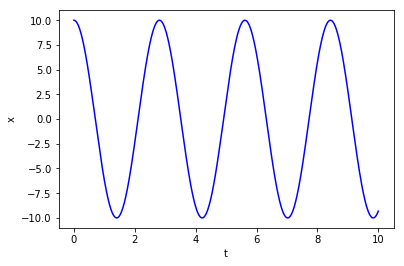

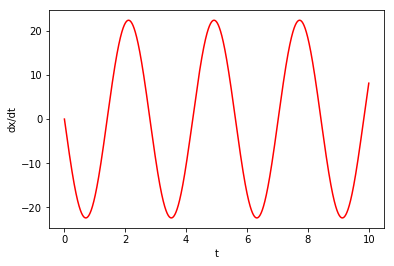

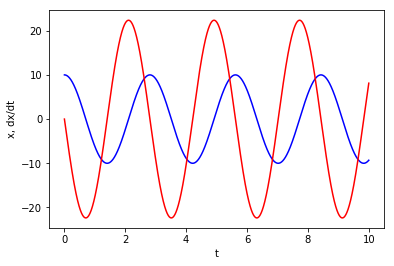

In [12]:
# plot the x and dx/dt vs. time (de las listas)
figure()
plot(t_list,x_list, ls='-', c='b')
xlabel('t')
ylabel('x')

figure()
plot(t_list,xd_list, ls='-', c='r')
xlabel('t')
ylabel('dx/dt')

figure()
plot(t_list,x_list, ls='-', c='b')
plot(t_list,xd_list, ls='-', c='r')
xlabel('t')
ylabel('x, dx/dt')

show()